In [2]:
import os
import time
import functools

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

In [3]:
print(tf.__version__)

2.16.1


Load and preprocess an image from a file path.

In [4]:
def preprocess_image(image_path):
    """Load and preprocess an image from a file path."""
    max_dim = 512
    
    # Read the image file
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Calculate new dimensions
    img_shape = tf.shape(img)[:-1]
    img_shape_float = tf.cast(img_shape, tf.float32)
    long_dim = tf.reduce_max(img_shape_float)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(img_shape_float * scale, tf.int32)
    
    # Resize and add batch dimension
    img = tf.image.resize(img, new_shape)
    img = tf.expand_dims(img, axis=0)
    
    return img


In [5]:
content_image_path = "content1.jpg"
style_image_path = "style1.jpg"

In [6]:
content_image = preprocess_image(content_image_path)
style_image = preprocess_image(style_image_path)

print(content_image.shape)
print(style_image.shape)


(1, 340, 512, 3)
(1, 286, 512, 3)


In [7]:
def plot_image(image, title = None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

Plot the content image

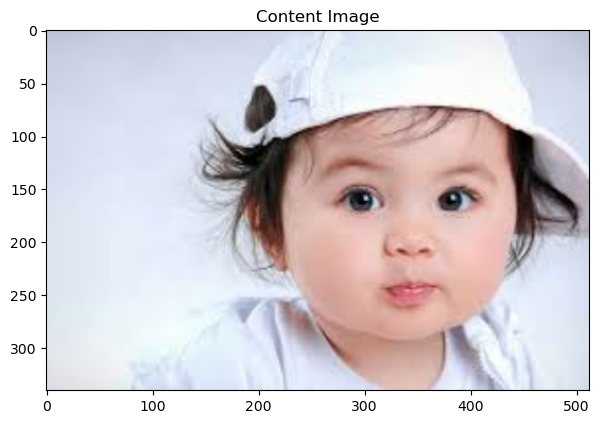

In [8]:
# Plot the content image
plt.figure(figsize=(7, 7))
plot_image(content_image, title="Content Image")
plt.show()

Plot the style image

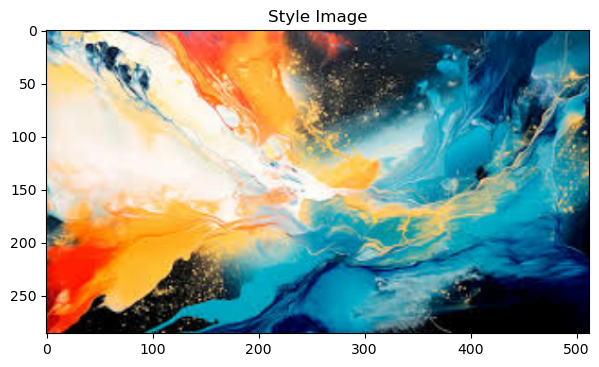

In [9]:
# Plot the style image
plt.figure(figsize=(7, 7))
plot_image(style_image, title="Style Image")
plt.show()

In [10]:
y = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
y = tf.image.resize(y, (224, 224))
print(y.shape)

(1, 224, 224, 3)


Load the VGG19 model and display model summary

In [11]:
# Load the VGG19 model
vgg_model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

# Display model summary
vgg_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#get the name of every layer of our model
for layer in vgg_model.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
content_layer = ["block5_conv2"]

num_content_layer = len(content_layer)

In [14]:
style_layer = ["block1_conv1",
               "block2_conv1",
               "block3_conv1",
               "block4_conv1",
               "block5_conv1"]

num_style_layer = len(style_layer)

In [15]:
def create_feature_extractor(layer_names):
    # Load the pre-trained model
    model = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    model.trainable = False
    
    # Get the output tensors of the specified layers
    outputs = [model.get_layer(name).output for name in layer_names]
    
    # Create a new model to extract features
    feature_extractor_model = tf.keras.Model(inputs= model.input, outputs=outputs)
    
    return feature_extractor_model


Create a feature extractor model for the style image and Extract style features from the style image

In [16]:
# Create a feature extractor model for the style image
style_image_feature_extractor = create_feature_extractor(style_layer)

# Extract style features from the style image
style_image_features = style_image_feature_extractor(style_image * 255)


In [17]:
for feature_map in style_image_features:
    print(feature_map.shape)

(1, 286, 512, 64)
(1, 143, 256, 128)
(1, 71, 128, 256)
(1, 35, 64, 512)
(1, 17, 32, 512)


Gram matrix calculation

In [36]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("fijc,fijd->fcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_location = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return (result / num_location)

In [37]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layer, content_layer):
        super(StyleContentModel, self).__init__()
        self.vgg = create_feature_extractor(style_layer + content_layer)
        self.style_layer = style_layer
        self.content_layer = content_layer
        self.num_style_layer = len(style_layer)
        self.vgg.trainable = False
    
    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[: self.num_style_layer],
                                        outputs[self.num_style_layer :])
        
        style_outputs = [gram_matrix(style_image_features) for style_image_features in style_outputs]
        content_dict = {content_name : value for content_name, value in zip(self.content_layer, content_outputs)}
        style_dict = {style_name : value for style_name, value in zip(self.style_layer, style_outputs)}
        return {"content" : content_dict, "style" : style_dict}

In [38]:
Model = StyleContentModel(style_layer, content_layer)
result = Model(tf.constant(content_image))

print("Styles")
for name, output in sorted(result["style"].items()):
    print(" ", name)
    print("shape", output.numpy().shape)
    print()

Styles
  block1_conv1
shape (1, 64, 64)

  block2_conv1
shape (1, 128, 128)

  block3_conv1
shape (1, 256, 256)

  block4_conv1
shape (1, 512, 512)

  block5_conv1
shape (1, 512, 512)



In [39]:
print("Content")
for name, output in sorted(result["content"].items()):
    print(" ", name)
    print("shape", output.numpy().shape)
    print()

Content
  block5_conv2
shape (1, 21, 32, 512)



In [40]:
style_targets = Model(style_image)["style"]
content_targets = Model(content_image)["content"]

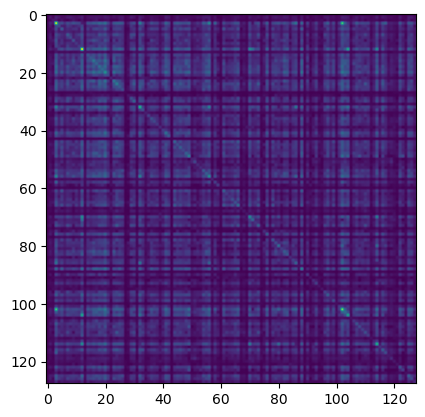

In [42]:
plt.imshow(style_targets["block2_conv1"].numpy()[0])

In [43]:
image = tf.Variable(content_image)

In [44]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [45]:
optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [46]:
style_weight = 1e-2
content_weight = 1e4

In [47]:
def content_style_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) **2)
                          for name in style_outputs.keys()])
    style_loss *= style_weight/num_style_layer
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) **2)
                          for name in content_outputs.keys()])
    content_loss *= content_weight/num_content_layer
    
    loss = style_loss + content_loss
    return loss

In [51]:
@tf.function
def train_steps(image):
    with tf.GradientTape() as tape:
        outputs = Model(image)
        loss = content_style_loss(outputs)
        gradient = tape.gradient(loss, image)
        optimizer.apply_gradients([(gradient, image)])
        image.assign(clip_0_1(image))

In [52]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype= np.uint8)
    if np.ndim(tensor) >3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

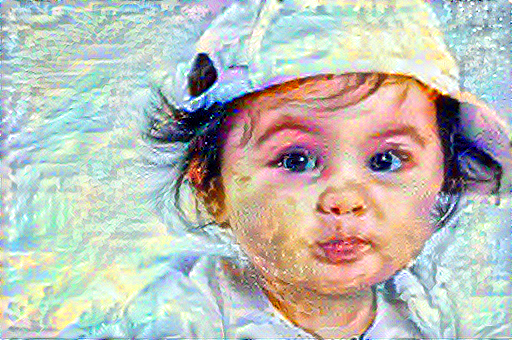

In [ ]:
import IPython.display as display
epochs = 10
steps_per_epoch = 100
step = 0

for epoch in range(epochs):
    for steps in range(steps_per_epoch):
        step += 1
        train_steps(image)
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))